In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian
from Neural_Network import NLM
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

In [3]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot

    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.2, color='green', label='class 2')


    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    print(n)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        xx = polynomial_features.fit_transform(xx)

    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5

    i = 0

    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes, forward, weights):
        self.intercept = intercept
        self.slopes = slopes
        self.forward = forward
        self.weights = weights

    def predict(self, x):
        print(x.shape)
        print(self.slopes.shape)
        #y = sigmoid((x.reshape(-1,20)).dot(self.slopes) + self.intercept)
        #y = sigmoid((x).dot(self.slopes) + self.intercept)
        y=self.forward(self.weights, x.T)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

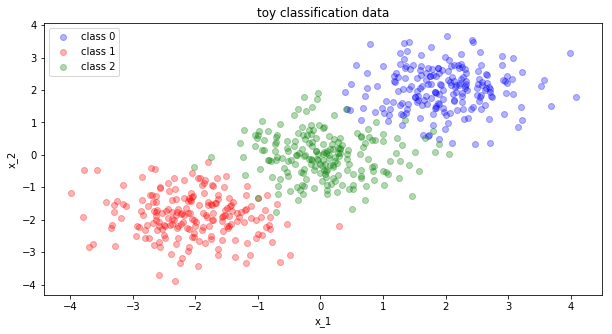

In [4]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params = [params_1, params_2,params_3]
x, y = two_clusters_gaussian(params, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 3 classes
* output dim =3
* 2000 samples, step size 1e-2m

In [5]:
class Feedforward:

    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = ((architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width'] ** 2 + architecture['width'])
                  )  # in order: input, output, hidden. Take into account the biases

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))

    def forward(self, weights, x):
        """ Forward pass given weights and input """
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        # input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        # additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        def softmax(y):   
            return np.exp(y - np.max(y))/(np.exp(y - np.max(y)).sum())

        def sigmoid(y):   
            return 1/(1 + np.exp(-y))

       # output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = softmax(np.matmul(W, input) + b)  # review that for training
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            sigmoid_probability = self.forward(W, x_train)
            sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
            #bce = np.dot(np.log(sigmoid_probability),y_train.flatten()) + np.dot(np.log(1 - sigmoid_probability),(1 - y_train.flatten())) ##true only for k=2
            bce = np.dot(np.log(sigmoid_probability),y_train.flatten()).sum()
            if reg_param is None:
                sum_error = bce
                return -sum_error
            else:
                mean_error = bce + reg_param * np.linalg.norm(W)
                return -mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(
                    self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [6]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn2 = Feedforward(architecture, random=random)

In [7]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn2.fit(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 14158.235464642981; gradient mag: 5013.716150480425
Iteration 100 lower bound 13788.388694191413; gradient mag: 606.1276736004489
Iteration 200 lower bound 13698.25164119834; gradient mag: 528.4409585945102
Iteration 300 lower bound 13608.220077044301; gradient mag: 471.3829207672193
Iteration 400 lower bound 13386.951795714309; gradient mag: 570.2453224918777
Iteration 500 lower bound 13114.290126323556; gradient mag: 541.860054287788
Iteration 600 lower bound 12926.021801438157; gradient mag: 283.9350684219607
Iteration 700 lower bound 12864.28335200304; gradient mag: 187.11334419809398
Iteration 800 lower bound 12821.163068453781; gradient mag: 145.4837637027425
Iteration 900 lower bound 12791.82436435116; gradient mag: 120.02096564314549
Iteration 1000 lower bound 12763.982446251684; gradient mag: 104.58628899985506
Iteration 1100 lower bound 12747.061916833038; gradient mag: 86.16159135532583
Iteration 1200 lower bound 12738.395517492916; gradient mag: 67.6

KeyboardInterrupt: 

In [ ]:
print(nn2.forward(nn2.weights,x.T)[0][0][:100],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][100:200],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][200:],'\n')

In [9]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn2.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn2.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - (nn2.forward(W, x.T)))**2, axis=2).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)


log_likelihood(nn2.weights)

100 : 0.99 False
200 : 0.975 False
300 : 0.9633333333333334 False
400 : 0.93 False
500 : 0.906 False
600 : 0.9 False
700 : 0.8871428571428571 False
800 : 0.86875 False
900 : 0.86 False
1000 : 0.86 False
1100 : 0.8572727272727273 False
1200 : 0.8666666666666667 False
1300 : 0.8523076923076923 False
1400 : 0.8621428571428571 False
1500 : 0.8546666666666667 False
1600 : 0.856875 False
1700 : 0.8647058823529412 False
1800 : 0.8722222222222222 False
1900 : 0.8752631578947369 False


-2133.2993496196264

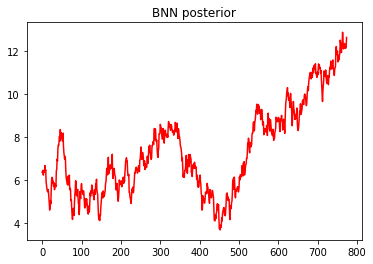

In [10]:
q_=np.asarray(q).T
plt.plot(range(len(q_[0])),q_[0] , color='r')
plt.title('BNN posterior')
plt.show()

120
(14400, 2)
(92,)


ValueError: cannot reshape array of size 43200 into shape (120,120)

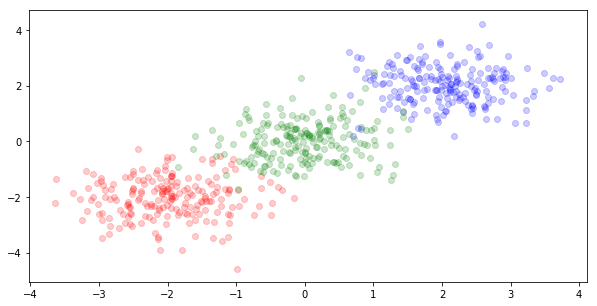

In [27]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn2.weights[0][-1],nn2.weights[0][:-1],nn2.forward,nn2.weights)
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# NLM

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)
nlm.fit_MLE(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 5079.294904173319; gradient mag: 4932.130958486966
Iteration 100 lower bound 4571.339595844374; gradient mag: 611.5150569035245
Iteration 200 lower bound 4420.73034699955; gradient mag: 326.2279706116367
Iteration 300 lower bound 4347.038203869032; gradient mag: 158.06935095568826
Iteration 400 lower bound 4320.117038353735; gradient mag: 113.92518290664694
Iteration 500 lower bound 4303.989343513185; gradient mag: 88.15245699699386
Iteration 600 lower bound 4293.018903744563; gradient mag: 72.96549119301919
Iteration 700 lower bound 4285.405236369908; gradient mag: 59.47031991870929
Iteration 800 lower bound 4280.659882054756; gradient mag: 47.38290534702393
Iteration 900 lower bound 4276.761716366223; gradient mag: 46.25264225188212
Iteration 1000 lower bound 4273.062576761429; gradient mag: 41.1865597869098
Iteration 1100 lower bound 4270.193357690087; gradient mag: 38.04691083312445
Iteration 1200 lower bound 4267.739917176531; gradient mag: 33.9036807083719

Iteration 10500 lower bound 4238.274165808597; gradient mag: 7.879152916428267
Iteration 10600 lower bound 4238.244304119223; gradient mag: 6.973276360675394
Iteration 10700 lower bound 4238.215988930081; gradient mag: 6.163177552941104
Iteration 10800 lower bound 4238.189190614697; gradient mag: 6.341420484296451
Iteration 10900 lower bound 4238.163777524081; gradient mag: 6.49451165511529
Iteration 11000 lower bound 4238.138562461049; gradient mag: 8.946721459958617
Iteration 11100 lower bound 4238.110808877932; gradient mag: 3.8236016686181022
Iteration 11200 lower bound 4238.084603413925; gradient mag: 6.259507206925926
Iteration 11300 lower bound 4238.056829773981; gradient mag: 3.8919887745359016
Iteration 11400 lower bound 4238.03151986051; gradient mag: 10.33250565045179
Iteration 11500 lower bound 4238.012217573517; gradient mag: 7.80201929925027
Iteration 11600 lower bound 4237.979816759411; gradient mag: 3.7994252880279653
Iteration 11700 lower bound 4237.954599215012; gradi

In [7]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

sigmoid_probability=nlm.forward(nlm.weights, x.T)
sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
bce = np.dot(np.log(sigmoid_probability),y.flatten())
bce1 = sum([np.dot(np.log(sigmoid_probability)[:,:,i],y.flatten()[i]) for i in range(len(y.flatten()))])
#-sum([p[i]*log2(q[i]) for i in range(len(p))])
#print(bce,'\n',bce1)


nlm.forward(nlm.weights,x.T)[0][0].reshape(3,-1)


array([[1.27780314e-09, 1.38795167e-12, 1.05730483e-12, 2.61426887e-04,
        4.27884057e-09, 1.80084168e-09, 7.63562123e-13, 4.28096138e-11,
        2.13897832e-10, 1.48372934e-07, 7.32999013e-09, 5.93179753e-14,
        5.17740538e-10, 3.97108604e-06, 1.46949712e-12, 5.87089301e-13,
        3.53616637e-18, 6.43176470e-06, 2.98421466e-04, 1.59075421e-07,
        4.55750294e-13, 4.79966123e-09, 4.89295289e-10, 2.44223377e-16,
        1.71479709e-09, 2.01728093e-08, 7.40810938e-09, 1.83164787e-10,
        1.81497907e-12, 3.27719313e-04, 1.34383660e-15, 5.21417021e-12,
        3.86572217e-11, 8.37821185e-13, 3.46454707e-10, 5.59627727e-15,
        1.55858144e-05, 4.02799051e-13, 1.31930335e-12, 3.00849249e-06,
        3.65331692e-07, 3.92492747e-13, 1.58813895e-12, 1.00724517e-06,
        8.26135653e-10, 1.13277230e-12, 1.84500653e-14, 1.55917018e-06,
        8.80623797e-16, 1.42352061e-06, 2.81137919e-09, 3.66429950e-10,
        1.40112342e-06, 1.91923285e-08, 1.28947748e-08, 4.274438

In [8]:
print(nlm.weights)
nlm.fit_NLM(x.T, y.reshape(1,-1),hmc,params_hmc)

[[ 3.1089863   0.6828795   1.2991278   3.27226602  2.83118204 -0.28462259
   0.79910624  0.30650745  0.42001222  0.32318271 -2.20514091  0.72237578
   1.14313416 -0.54228225  1.00686694 -0.04478214  1.88008944 -1.33187258
  -0.17190035 -0.94621332 -4.83087724  0.39198575 -0.70790068 -2.92660417
   1.53929766 -5.32701059  1.47042118 -1.35943203 -0.15299444  0.5227377
   0.04952452 -0.09611067 -0.31169079  0.1161419  -0.81710774 -0.29281062
   0.43258994  1.31649267 -0.28847661  2.99833855 -1.54129374 -1.71564697
  -2.21776306  2.77927303 -1.23637149 -2.30826268 -2.60651649  3.61721129
  -1.98219765 -0.48885579 -2.30736917 -2.60552932  3.61581405 -1.98223342
  -0.48886516 -2.1117279  -2.38701544  3.30872554 -1.98768101 -0.49062791
  -0.65032019 -0.65021156 -0.63563691]]
Autograd ArrayBox with value [[ 3.1089863   0.6828795   1.2991278   3.27226602  2.83118204 -0.28462259
   0.79910624  0.30650745  0.42001222  0.32318271 -2.20514091  0.72237578
   1.14313416 -0.54228225  1.00686694 -0.044

AssertionError: 